# TASK 3 - linear regression sales prediction

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

In [ ]:
df = pd.read_csv("train.csv", parse_dates=["date"])
print(df)

              id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0               

In [ ]:
print("Aggregating to daily totals :")
daily = df.groupby('date').agg({
    'sales': 'sum',
    'onpromotion': 'sum'
}).reset_index().sort_values('date')
print(daily)

Aggregating to daily totals :
           date          sales  onpromotion
0    2013-01-01    2511.618999            0
1    2013-01-02  496092.417944            0
2    2013-01-03  361461.231124            0
3    2013-01-04  354459.677093            0
4    2013-01-05  477350.121229            0
...         ...            ...          ...
1679 2017-08-11  826373.722022        14179
1680 2017-08-12  792630.535079         8312
1681 2017-08-13  865639.677471         9283
1682 2017-08-14  760922.406081         8043
1683 2017-08-15  762661.935939        10605

[1684 rows x 3 columns]


In [ ]:
print("Feature engineering :")
daily['day'] = daily['date'].dt.day
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['dayofweek'] = daily['date'].dt.dayofweek
daily['is_weekend'] = daily['dayofweek'].isin([5,6]).astype(int)
print(daily['is_weekend'])

Feature engineering :
0       0
1       0
2       0
3       0
4       1
       ..
1679    0
1680    1
1681    1
1682    0
1683    0
Name: is_weekend, Length: 1684, dtype: int64


In [ ]:
daily = daily.sort_values('date').reset_index(drop=True)
daily['trend'] = np.arange(len(daily))

In [ ]:
feature_cols = ['trend', 'onpromotion', 'is_weekend']

dayofweek_ohe = pd.get_dummies(daily['dayofweek'], prefix='dow')
month_ohe = pd.get_dummies(daily['month'], prefix='m')

X = pd.concat([daily[feature_cols], dayofweek_ohe, month_ohe], axis=1)
y = daily['sales']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (1684, 22)
Target shape: (1684,)


In [ ]:
n_dates = len(daily)
split_index = int(n_dates * 0.8)
X_train = X.iloc[:split_index].copy()
X_test  = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index].copy()
y_test  = y.iloc[split_index:].copy()

print(f"Train on {X_train.shape[0]} days, test on {X_test.shape[0]} days (chronological split).")

Train on 1347 days, test on 337 days (chronological split).


In [ ]:
print("Training Linear Regression model :")
model = LinearRegression()
model.fit(X_train, y_train)

Training Linear Regression model :


LinearRegression()

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

metrics = {
    "train_rmse": rmse(y_train, y_pred_train),
    "train_mae": mean_absolute_error(y_train, y_pred_train),
    "train_r2": r2_score(y_train, y_pred_train),
    "test_rmse": rmse(y_test, y_pred_test),
    "test_mae": mean_absolute_error(y_test, y_pred_test),
    "test_r2": r2_score(y_test, y_pred_test),
}

print("Evaluation metrics:")
for k,v in metrics.items():
    print(f"  {k}: {v:.4f}")

Evaluation metrics:
  train_rmse: 106004.8323
  train_mae: 80033.0621
  train_r2: 0.7568
  test_rmse: 157119.1919
  test_mae: 129115.8945
  test_r2: 0.2837


Plotting actual vs predicted for test set...


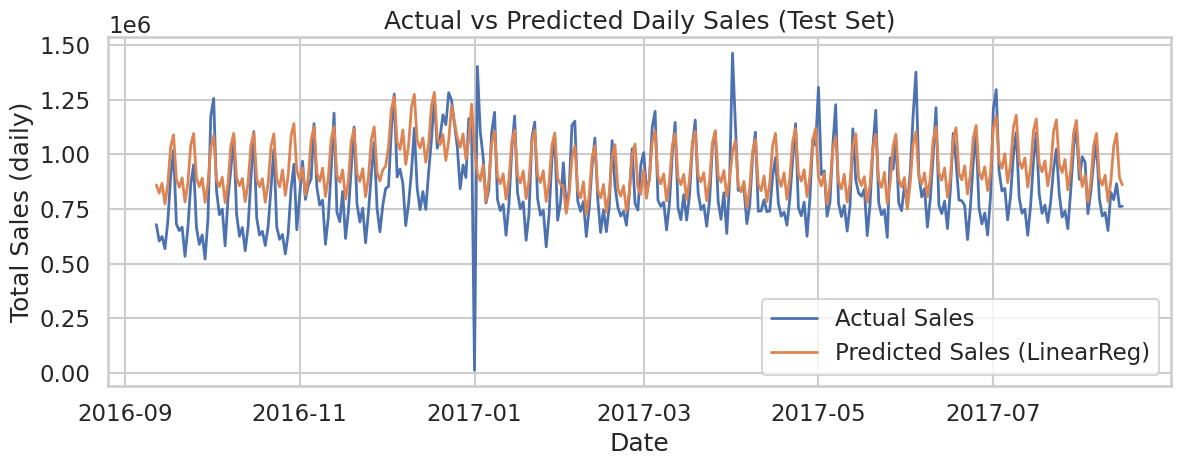

In [ ]:
# Plot actual vs predicted
print("Plotting actual vs predicted for test set...")
test_dates = daily['date'].iloc[split_index:].reset_index(drop=True)
plt.figure(figsize=(12,5))
plt.plot(test_dates, y_test.values, label='Actual Sales', linewidth=2)
plt.plot(test_dates, y_pred_test, label='Predicted Sales (LinearReg)', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Total Sales (daily)')
plt.title('Actual vs Predicted Daily Sales (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()